# Deep Convolutional Generative Adversarial Network

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow.keras.layers as layers
import time
import tensorflow as tf

### Load and prepare the MNIST dataset to train the generator and the discriminator.

In [ ]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
train_images.shape[0]

11490434/11490434 [==============================] - 0s 0us/step


60000

In [ ]:
BUFFER_SIZE = 60000
batch_size = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(batch_size)

## Create the models



In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()

    # 'projection'
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
      
    model.add(layers.Reshape((7, 7, 256)))
          
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)       

In [ ]:
noise = tf.random.normal([1, 3, 3, 32])
print(noise.shape)
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

(1, 3, 3, 32)


ValueError: ignored

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), 
                            strides=(2, 2), 
                            padding='same', 
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
      
    model.add(layers.Conv2D(128, (5, 5), 
                            strides=(2, 2), 
                            padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
       
    model.add(layers.Conv2D(1, (3, 3)))
     
    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_13 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 5, 5, 1)          

In [ ]:
# optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    '''
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    '''

    labels = tf.concat([tf.zeros_like(fake_output), tf.ones_like(real_output)], axis=0)
    combined_images = tf.concat([fake_output, real_output], axis=0)
    loss = cross_entropy(labels, combined_images)

    return loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Define the training loop



In [ ]:
EPOCHS = 100
num_examples_to_generate = 25

seed = tf.random.normal([num_examples_to_generate, 100])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def generate_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(5,5))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        imagen = predictions[i].numpy().reshape((28,28))
        plt.imshow(imagen * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    label = 'Epoch {0}'.format(epoch)
    fig.text(0.51, 0.05, label, ha='center',fontsize=14)
    plt.show()

In [ ]:
def train(dataset, epochs):  
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        if epoch%10 == 0:    
            generate_images(generator, epoch + 1, seed)

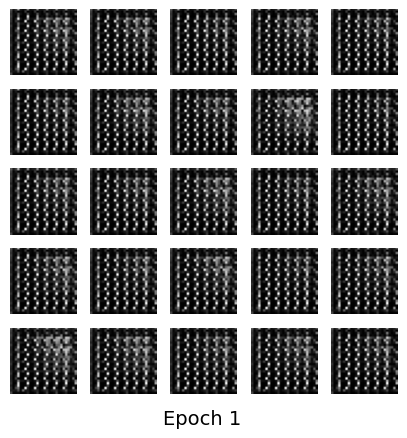

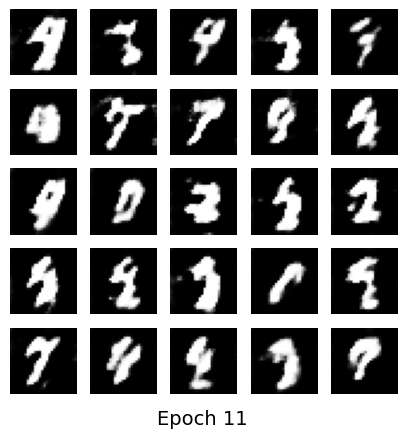

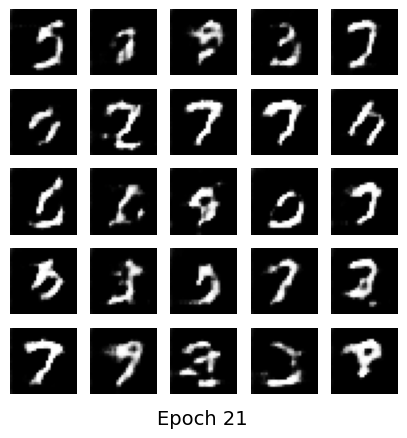

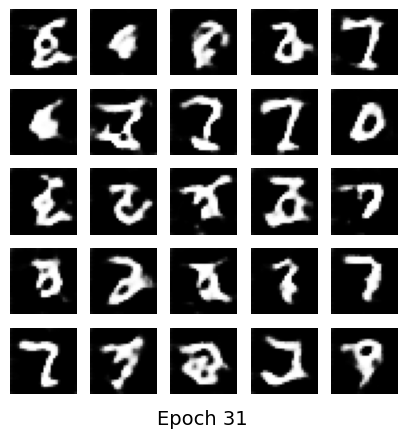

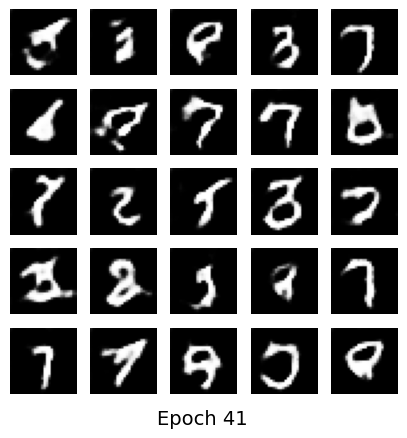

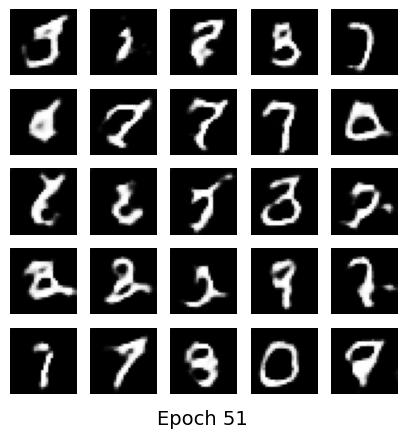

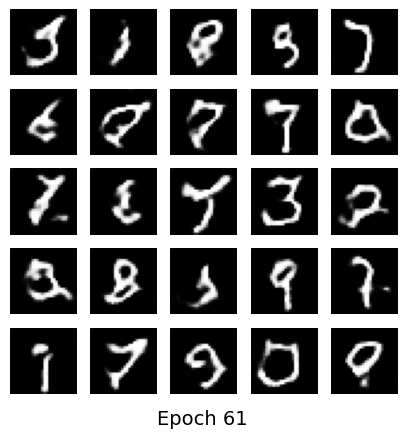

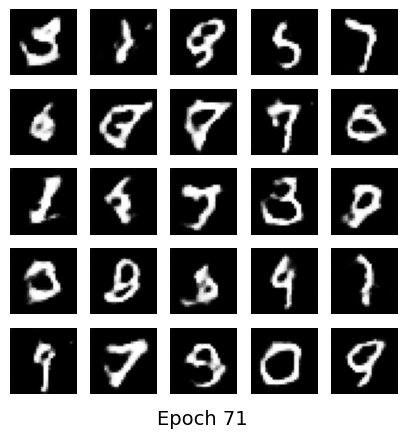

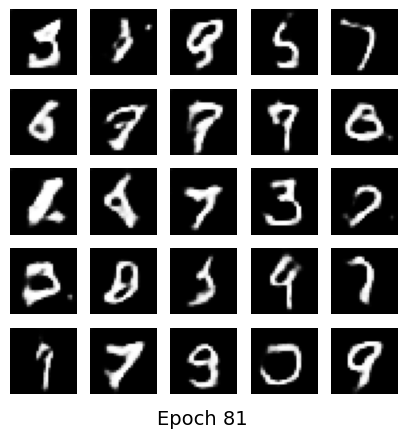

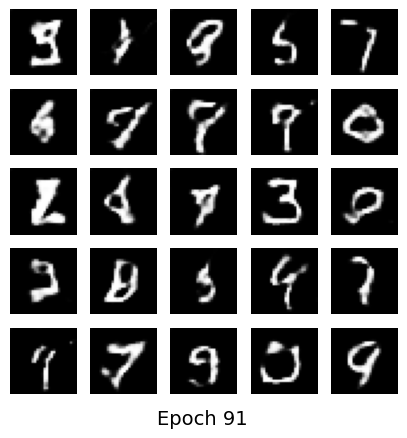

In [ ]:
train(train_dataset, EPOCHS)